# Optimising maize crop yields in Sub-Saharan Africa in the context of climate change

<Optimising maize crop yields in Sub-Saharan Africa in the context of climate change>

# Probleme statement 

African countries have been suffering from food shortages for decades, and all stakeholders are trying to find a solution to this age-old problem. With climate change, agricultural yields are decreasing significantly. In this project we will try to answer the following question: **"How can maize yields in sub-Saharan Africa be optimised in the context of climate change?"** The aim of this project is to improve maize yields in the context of extreme climate change in sub-Saharan Africa. More specifically, it aims to:
- Map the climatic environment of sub-Saharan Africa;
- Describe maize crop yields by sub-region (Central, West, East Africa, etc.);
- Assess the impact of climate change on maize yields;
- Predict maize yields as a function of climatic events.

# Import the packages 

In [487]:
import warnings
from glob import glob
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import plotly.express as px
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import tensorflow as tf
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
warnings.simplefilter(action="ignore", category=FutureWarning)

# Data Preparation 

### import the data 

> We create a function called **clean** to import the data and wrangle the datas 

In [488]:
def clean(path):
    df=pd.read_csv(path)
    #Rename the features to ease the analysis
    df=df.rename(columns={'Country Code':"iso3",
       'Agricultural land (% of land area) [AG.LND.AGRI.ZS]':"feat1",
       'Agricultural land (sq. km) [AG.LND.AGRI.K2]':"feat2",
       'Arable land (% of land area) [AG.LND.ARBL.ZS]':"feat3",
       'Arable land (hectares per person) [AG.LND.ARBL.HA.PC]':"feat4",
       'Population growth (annual %) [SP.POP.GROW]':"feat5",
       'Population ages 15-64, male (% of male population) [SP.POP.1564.MA.ZS]':"feat6",
       'Population ages 15-64, female (% of female population) [SP.POP.1564.FE.ZS]':"feat7",
       'Population ages 15-64 (% of total population) [SP.POP.1564.TO.ZS]':"feat8",
       'Urban population (% of total population) [SP.URB.TOTL.IN.ZS]':"feat9",
       'Employment in agriculture (% of total employment) (modeled ILO estimate) [SL.AGR.EMPL.ZS]':"feat10",
       'Employment in agriculture, female (% of female employment) (modeled ILO estimate) [SL.AGR.EMPL.FE.ZS]':"feat11"})
    # Drop columns with missing value greater than 50%
    for column in df.columns:
        if df[column].isnull().sum()>len(df)/2:
            df.drop(columns=[column],inplace=True)
    #delate features will not be included in our model
    df.drop(columns=["Time","Country Name"],inplace=True)
    #Replace NA values by the mean
    df=df.fillna(df.mean())
    #subset and remove outliers from maize yield feature
    q1,q9=df['maize'].quantile([0.1,0.9])
    mask_maize=df['maize'].between(q1,q9)
    df=df[mask_maize]
    #Index countrycode
    #df=df.set_index('iso3')
    return df

In [489]:
df=clean('Data3.csv')

### Explore

In [490]:
df.head()

,iso3,maize,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11
0,AGO,10836.0,36.814791,458970.0,4.309778,0.155722,3.166030,51.794773,52.648165,52.226425,67.460,58.65716,65.73271
1,BEN,12064.0,35.030153,39500.0,24.831501,0.215436,2.759705,54.189234,54.502531,54.345611,48.972,28.14955,13.07583
2,BWA,7980.0,45.633723,258620.0,0.458772,0.100447,1.636743,63.295558,63.684988,63.492752,71.560,23.07407,16.44704
3,BFA,17238.0,46.564327,127400.0,22.295322,0.276010,2.650376,52.990508,53.730505,53.361834,31.240,73.26725,76.05038
4,BDI,15556.0,81.892523,21030.0,49.454829,0.101185,2.672478,50.990671,51.466715,51.230355,14.058,85.85030,93.65079


In [462]:
print("The shape of data is :",df.shape)
df.info()

The shape of data is : (39, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 0 to 48
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   iso3    39 non-null     object 
 1   maize   39 non-null     float64
 2   feat1   39 non-null     float64
 3   feat2   39 non-null     float64
 4   feat3   39 non-null     float64
 5   feat4   39 non-null     float64
 6   feat5   39 non-null     float64
 7   feat6   39 non-null     float64
 8   feat7   39 non-null     float64
 9   feat8   39 non-null     float64
 10  feat9   39 non-null     float64
 11  feat10  39 non-null     float64
 12  feat11  39 non-null     float64
dtypes: float64(12), object(1)
memory usage: 4.3+ KB


The target value is numeric and all explanatory variables are also numerci.

In [463]:
print(df.isna().sum())

iso3      0
maize     0
feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
feat6     0
feat7     0
feat8     0
feat9     0
feat10    0
feat11    0
dtype: int64


In [464]:
print("The shape of data is:",df.shape)

The shape of data is: (39, 13)


In [465]:
print("Dunplicated:",df.duplicated().sum())

Dunplicated: 0


#### Cheick the cordinality

In [466]:
df.select_dtypes('object').nunique()

iso3    39
dtype: int64

In [468]:
df.select_dtypes('object').nunique()

iso3    39
dtype: int64

The **48 subsaharan countries** are represented

#### check for leakage

In [470]:
sorted(df.columns)

['feat1',
 'feat10',
 'feat11',
 'feat2',
 'feat3',
 'feat4',
 'feat5',
 'feat6',
 'feat7',
 'feat8',
 'feat9',
 'iso3',
 'maize']

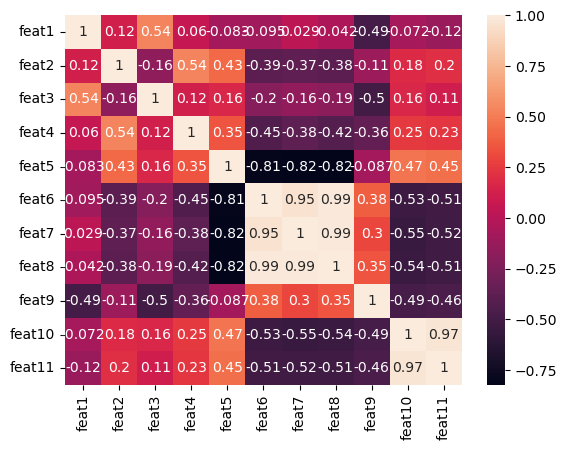

In [471]:
corr=df.select_dtypes("number").drop(columns="maize").corr()
sns.heatmap(corr,annot=True);

In [472]:
round(corr,3)

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11
feat1,1.000,0.116,0.536,0.060,-0.083,-0.095,0.029,-0.042,-0.494,-0.072,-0.121
feat2,0.116,1.000,-0.163,0.537,0.427,-0.385,-0.370,-0.383,-0.112,0.177,0.202
feat3,0.536,-0.163,1.000,0.117,0.161,-0.205,-0.159,-0.186,-0.503,0.160,0.111
feat4,0.060,0.537,0.117,1.000,0.345,-0.446,-0.380,-0.421,-0.359,0.250,0.235
feat5,-0.083,0.427,0.161,0.345,1.000,-0.806,-0.824,-0.824,-0.087,0.472,0.447
feat6,-0.095,-0.385,-0.205,-0.446,-0.806,1.000,0.954,0.991,0.381,-0.527,-0.506
feat7,0.029,-0.370,-0.159,-0.380,-0.824,0.954,1.000,0.986,0.300,-0.548,-0.517
feat8,-0.042,-0.383,-0.186,-0.421,-0.824,0.991,0.986,1.000,0.349,-0.540,-0.514
feat9,-0.494,-0.112,-0.503,-0.359,-0.087,0.381,0.300,0.349,1.000,-0.488,-0.463
feat10,-0.072,0.177,0.160,0.250,0.472,-0.527,-0.548,-0.540,-0.488,1.000,0.967


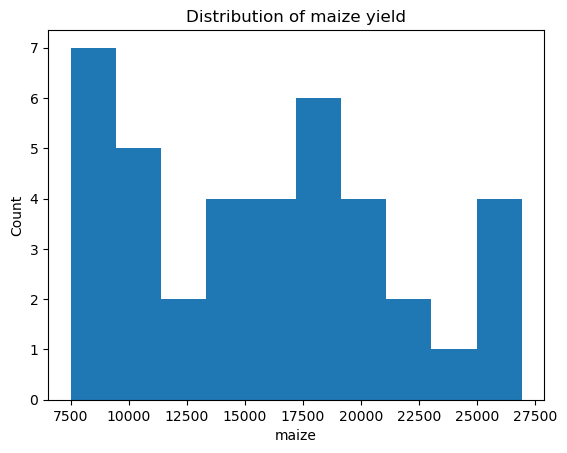

In [473]:
plt.hist(df["maize"])
plt.xlabel("maize")
plt.ylabel("Count")
plt.title("Distribution of maize yield");

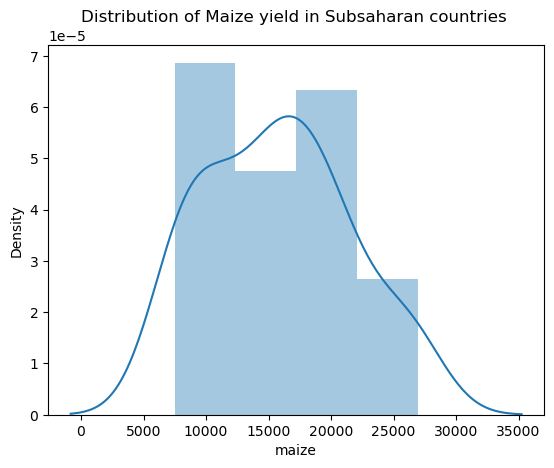

In [474]:
# Data distribution
plt.title('Distribution of Maize yield in Subsaharan countries ')
sns.distplot(df['maize'])
plt.show()

- The distribution is not far from the normality

In [475]:
#mean of maize by country
mean_maize_by_state=df.groupby('iso3')['maize'].mean().sort_values(ascending=True)

In [476]:
df.head()

,iso3,maize,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11
0,AGO,10836.0,36.814791,458970.0,4.309778,0.155722,3.166030,51.794773,52.648165,52.226425,67.460,58.65716,65.73271
1,BEN,12064.0,35.030153,39500.0,24.831501,0.215436,2.759705,54.189234,54.502531,54.345611,48.972,28.14955,13.07583
2,BWA,7980.0,45.633723,258620.0,0.458772,0.100447,1.636743,63.295558,63.684988,63.492752,71.560,23.07407,16.44704
3,BFA,17238.0,46.564327,127400.0,22.295322,0.276010,2.650376,52.990508,53.730505,53.361834,31.240,73.26725,76.05038
4,BDI,15556.0,81.892523,21030.0,49.454829,0.101185,2.672478,50.990671,51.466715,51.230355,14.058,85.85030,93.65079


- The plot shows that Zambia has higher maize yield ,following by Saotome de Principe ,Seychells,Gambia ,Ghinea,Mozambic and Biseau Guinea

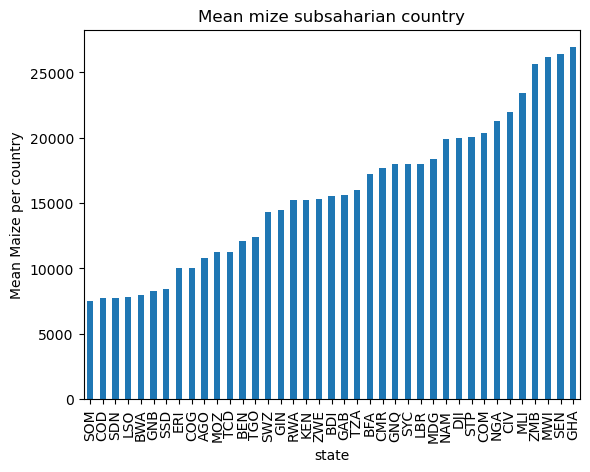

In [477]:
#Create a bar plot
mean_maize_by_state.plot(
       kind="bar",
       xlabel="state",
       ylabel="Mean Maize per country",
       title="Mean mize subsaharian country"
);

The plot clearly states that Ghana has the highest mean of maize yiled than any subsaharan country.Somali reprente small maize yield which is explain by secheresse

In [478]:
#describe Maize
df['maize'].describe().apply("{0:.0f}".format)

count       39
mean     15758
std       5774
min       7500
25%      11033
50%      15556
75%      19972
max      26923
Name: maize, dtype: object

In [479]:
df.describe()

,maize,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11
count,39.000000,39.000000,3.900000e+01,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,15757.606466,48.604741,2.078596e+05,13.848131,0.170668,2.293577,56.078135,56.297899,56.200182,45.495205,45.647855,46.812769
std,5773.633633,21.967386,2.362713e+05,14.822557,0.100300,0.620121,4.454191,3.767497,4.074795,18.329507,19.550955,23.432144
min,7500.000000,3.369565,1.550000e+01,0.129422,0.001511,0.805183,49.866459,50.019870,50.151164,14.058000,1.184986,0.917983
25%,11033.000000,35.188963,2.128118e+04,4.187844,0.100816,1.975253,53.347136,54.052583,53.730012,31.771500,30.432495,27.231400
50%,15556.000000,47.142562,1.260374e+05,10.190814,0.155722,2.378495,55.371702,55.843096,55.743353,44.677000,44.984287,47.604410
75%,19972.500000,69.855121,3.635500e+05,17.568143,0.224869,2.686762,58.082974,58.027463,58.026360,55.488500,61.764265,65.961655
max,26923.000000,81.892523,1.126648e+06,51.414674,0.459836,3.222528,71.149733,66.512145,68.955720,90.423000,85.850300,93.650790


In [199]:
#features=df[['feat1','feat2','feat3','feat4','feat5','feat6','feat7','feat8','feat9','feat10','feat11']]

In [314]:
#features.head()

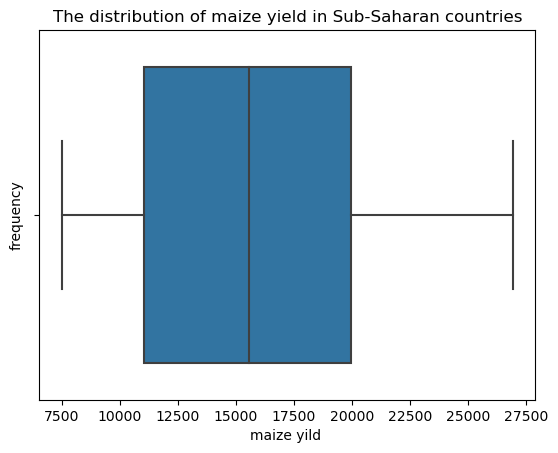

In [480]:
#sns.boxplot(x=df[features])
   # plt.title(feature);
sns.boxplot(x=df['maize'])
plt.xlabel("maize yild ")
plt.ylabel("frequency")
plt.title("The distribution of maize yield in Sub-Saharan countries");

- Maize yield is does not have outliers

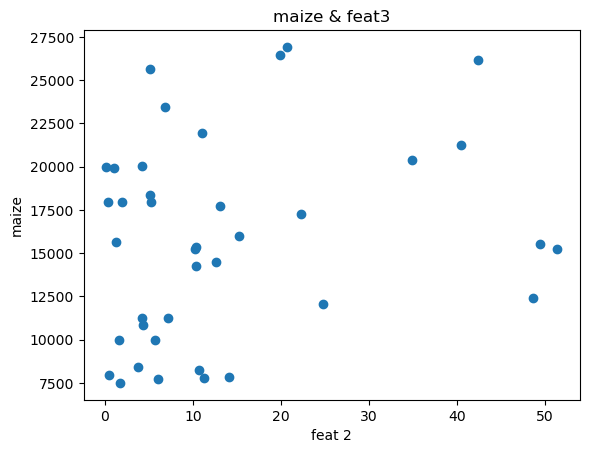

In [481]:
plt.scatter(x=df['feat3'],y=df['maize'])
plt.xlabel('feat 2')
plt.ylabel('maize')
plt.title('maize & feat3');

In [482]:
def build_nat_choropleth():
    fig = px.choropleth(
        data_frame=df,
        locations="iso3",
        color="maize",
        projection="natural earth",
        color_continuous_scale=px.colors.sequential.Oranges,
        title="Maize "
        
    )
    return fig
nat_fig = build_nat_choropleth()
print("nat_fig type:", type(nat_fig))
nat_fig.show()

nat_fig type: <class 'plotly.graph_objs._figure.Figure'>


In [295]:
#plt.figure(figsize=(10,10))
#for i,feature in enumerate(features):
#    plt.subplot(2,3,i+1)
#    sns.boxplot(x=data[feature])
 #   plt.title(feature);

In [58]:
#sns.pairplot(df[['maize','feat1','feat2','feat3','feat4','feat5','feat6','feat7','feat8','feat9','feat10','feat11']],diag_kind = 'kde');

In [491]:
df2=df.copy()

In [492]:
df2=df2.set_index('iso3')

In [ ]:
# Chech the outliers

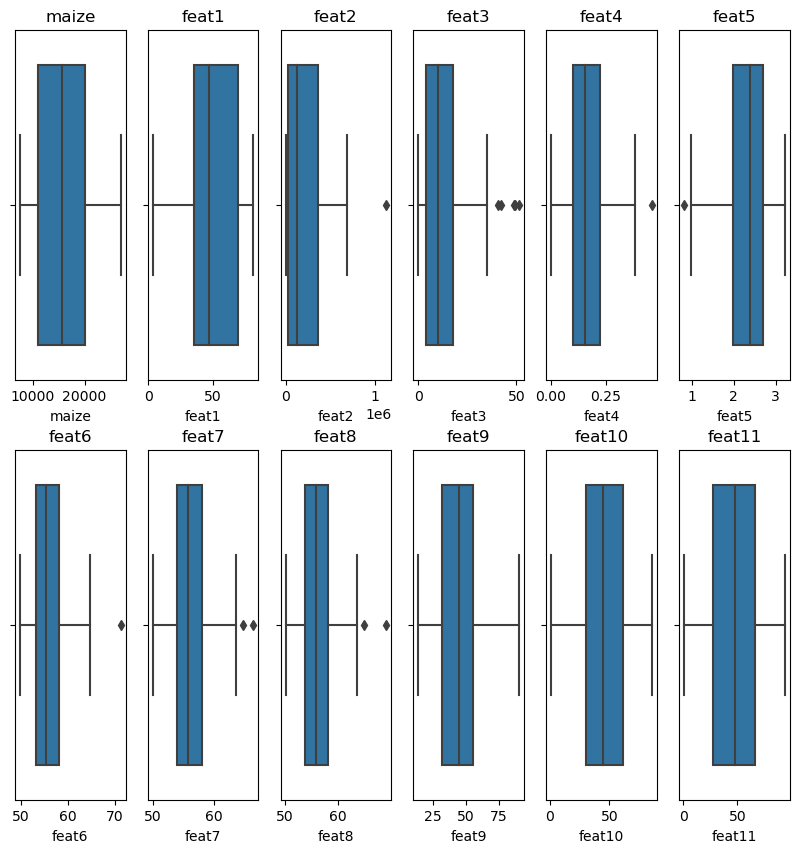

In [493]:
plt.figure(figsize=(10,10))
for i,feature in enumerate(df2):
    plt.subplot(2,6,i+1)
    sns.boxplot(x=df2[feature])
    plt.title(feature);

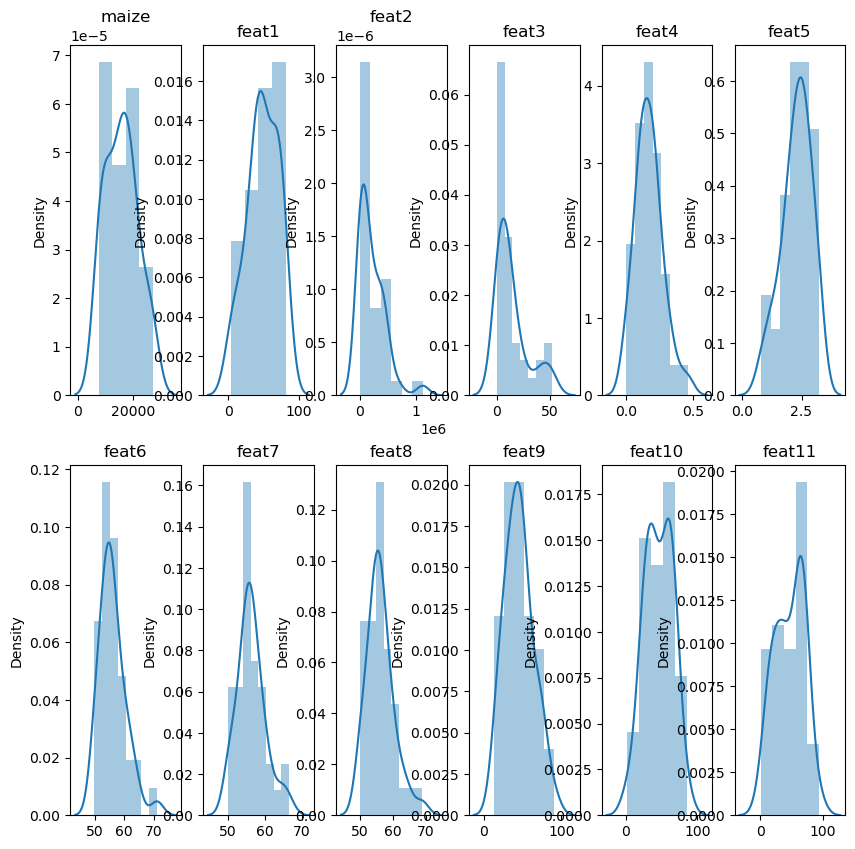

In [494]:
plt.figure(figsize=(10,10))
for i,feature in enumerate(df2):
    plt.subplot(2,6,i+1)
    sns.distplot(x=df2[feature])
    plt.title(feature);

In [268]:
#df2.drop(columns=('iso3'),inplace=True)

In [495]:
df2.head()

,maize,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11
iso3,,,,,,,,,,,,
AGO,10836.0,36.814791,458970.0,4.309778,0.155722,3.166030,51.794773,52.648165,52.226425,67.460,58.65716,65.73271
BEN,12064.0,35.030153,39500.0,24.831501,0.215436,2.759705,54.189234,54.502531,54.345611,48.972,28.14955,13.07583
BWA,7980.0,45.633723,258620.0,0.458772,0.100447,1.636743,63.295558,63.684988,63.492752,71.560,23.07407,16.44704
BFA,17238.0,46.564327,127400.0,22.295322,0.276010,2.650376,52.990508,53.730505,53.361834,31.240,73.26725,76.05038
BDI,15556.0,81.892523,21030.0,49.454829,0.101185,2.672478,50.990671,51.466715,51.230355,14.058,85.85030,93.65079


#### Future scaling

> Create your feature matrix X_train and target vector y_train. Your target is **"maize"**. Your features should be all the columns that remain in the DataFrame you cleaned above.

In [540]:
X=df.drop(columns=('maize'))
y=df['maize']

In [541]:
scaler=StandardScaler()
df2[['feat1','feat10','feat11','feat2','feat3','feat4','feat5','feat6','feat7','feat8','feat9','maize']]=scaler.fit_transform(
    df2[['feat1','feat10','feat11','feat2','feat3','feat4','feat5','feat6','feat7','feat8','feat9','maize']])

In [542]:
df.head()

,iso3,maize,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11
0,AGO,10836.0,36.814791,458970.0,4.309778,0.155722,3.166030,51.794773,52.648165,52.226425,67.460,58.65716,65.73271
1,BEN,12064.0,35.030153,39500.0,24.831501,0.215436,2.759705,54.189234,54.502531,54.345611,48.972,28.14955,13.07583
2,BWA,7980.0,45.633723,258620.0,0.458772,0.100447,1.636743,63.295558,63.684988,63.492752,71.560,23.07407,16.44704
3,BFA,17238.0,46.564327,127400.0,22.295322,0.276010,2.650376,52.990508,53.730505,53.361834,31.240,73.26725,76.05038
4,BDI,15556.0,81.892523,21030.0,49.454829,0.101185,2.672478,50.990671,51.466715,51.230355,14.058,85.85030,93.65079


# LINEAR REGRESSION MODEL

## Split data

In [543]:
target = "maize"
features=['feat1','feat10','feat11','feat2','feat3','feat4','feat5','feat6','feat7','feat8','feat9','iso3']
X_train =df[features]
y_train=df[target]

## Build te model

### Baseline

In [544]:
y_mean=y_train.mean()
y_pred_baseline=[y_mean]*len(y_train)
print("Mean apt price:",round(y_mean,2))

print("Baseline MAE:", round(mean_absolute_error(y_train,y_pred_baseline),2))

Mean apt price: 15757.61
Baseline MAE: 4711.01


### Iteration

- Create a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor.

In [545]:
model=LinearRegression()

In [546]:
# make insistiation
ohe=OneHotEncoder(use_cat_names=True)
#fit ohe
ohe.fit(X_train)
#Transform
XT_train=ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(39, 50)


,feat1,feat10,feat11,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,iso3_SYC,iso3_SSD,iso3_SDN,iso3_TZA,iso3_TGO,iso3_ZMB,iso3_ZWE,iso3_GNB,iso3_MLI,iso3_SOM
0,36.814791,58.65716,65.73271,458970.0,4.309778,0.155722,3.166030,51.794773,52.648165,52.226425,...,0,0,0,0,0,0,0,0,0,0
1,35.030153,28.14955,13.07583,39500.0,24.831501,0.215436,2.759705,54.189234,54.502531,54.345611,...,0,0,0,0,0,0,0,0,0,0
2,45.633723,23.07407,16.44704,258620.0,0.458772,0.100447,1.636743,63.295558,63.684988,63.492752,...,0,0,0,0,0,0,0,0,0,0
3,46.564327,73.26725,76.05038,127400.0,22.295322,0.276010,2.650376,52.990508,53.730505,53.361834,...,0,0,0,0,0,0,0,0,0,0
4,81.892523,85.85030,93.65079,21030.0,49.454829,0.101185,2.672478,50.990671,51.466715,51.230355,...,0,0,0,0,0,0,0,0,0,0


In [547]:
imputer=SimpleImputer()

In [548]:
model=make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['iso3'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

# Evaluate

 - Calculate the training mean absolute error for your predictions as compared to the true targets in y_train.

In [549]:
y_pred_training=model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train,y_pred_training))

Training MAE: 2047.2084702542618


## communicate Results